# Random Forest Deforestation Detection - Ca Mau Province

**Project:** Deforestation Monitoring using Remote Sensing and Machine Learning
**Student:** Ninh Hai Dang (ID: 21021411)

## Pipeline
1. Setup → 2. Load Data → 3. Features → 4. Training Data → 5. Train → 6. Evaluate → 7. Cross-Val → 8. Predict → 9. Visualize → 10. Summary

In [1]:
import os
import sys

# Change to src directory for imports
if os.path.basename(os.getcwd()) == 'notebook':
    os.chdir('..')
    
# Add src to path
sys.path.insert(0, 'src')

print(f'Working directory: {os.getcwd()}')
print(f'Python path includes: src/')

Working directory: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH
Python path includes: src/


## 1. Setup & Import

In [2]:
# Create output directories
from pathlib import Path

plots_dir = Path('results/plots')
plots_dir.mkdir(parents=True, exist_ok=True)

print(f'[OK] Output directories created: {plots_dir}')

[OK] Output directories created: results\plots


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

from config import print_config_summary, create_output_directories, verify_input_files, FEATURE_NAMES
from core.data_loader import DataLoader
from core.feature_extraction import FeatureExtraction
from core.evaluation import ModelEvaluator
from models.rf.trainer import RandomForestTrainer, TrainingDataExtractor
from models.rf.predictor import RasterPredictor

print("[OK] All modules imported!")

[OK] All modules imported!


## 2. Load Data

In [4]:
%%time
loader = DataLoader()

print("Loading Sentinel-2...")
s2_before, s2_after = loader.load_sentinel2()

print("Loading Sentinel-1...")
s1_before, s1_after = loader.load_sentinel1()

print("Loading Ground Truth...")
ground_truth = loader.load_ground_truth()

data = {
    's2_before': s2_before, 's2_after': s2_after,
    's1_before': s1_before, 's1_after': s1_after,
    'ground_truth': ground_truth, 'metadata': loader.metadata
}

print("[OK] Data loaded!")

2025-11-14 16:39:37 - core.data_loader - INFO - 
2025-11-14 16:39:37 - core.data_loader - INFO - LOADING SENTINEL-2 DATA (OPTICAL)
2025-11-14 16:39:37 - core.data_loader - INFO - ======================================================================
2025-11-14 16:39:37 - core.data_loader - INFO - Loading Sentinel-2 Before (2024-01-30): d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\data\raw\sentinel-2\S2_2024_01_30.tif


Loading Sentinel-2...


2025-11-14 16:40:00 - core.data_loader - INFO -   [OK] Shape: (7, 10917, 12547)
2025-11-14 16:40:00 - core.data_loader - INFO -   [OK] Bands: 7
2025-11-14 16:40:00 - core.data_loader - INFO -   [OK] CRS: EPSG:32648
2025-11-14 16:40:00 - core.data_loader - INFO -   [OK] NoData: 0.0
2025-11-14 16:40:11 - core.data_loader - INFO - Loading Sentinel-2 After (2025-02-28): d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\data\raw\sentinel-2\S2_2025_02_28.tif
2025-11-14 16:40:37 - core.data_loader - INFO -   [OK] Shape: (7, 10917, 12547)
2025-11-14 16:40:37 - core.data_loader - INFO -   [OK] Bands: 7
2025-11-14 16:40:37 - core.data_loader - INFO -   [OK] CRS: EPSG:32648
2025-11-14 16:40:37 - core.data_loader - INFO -   [OK] NoData: 0.0
2025-11-14 16:40:49 - core.data_loader - INFO - 
[OK] Sentinel-2 data loaded successfully
2025-11-14 16:40:49 - core.data_loader - INFO -   - Expected bands: ['B4', 'B8', 'B11', 'B12', 'NDVI', 'NBR', 'NDMI']
2025-11-14 16:40:49 - core.data_loader - INFO - 
2025-11-

Loading Sentinel-1...


2025-11-14 16:40:55 - core.data_loader - INFO -   [OK] Shape: (2, 10917, 12547)
2025-11-14 16:40:55 - core.data_loader - INFO -   [OK] Bands: 2
2025-11-14 16:40:55 - core.data_loader - INFO -   [OK] CRS: EPSG:32648
2025-11-14 16:40:55 - core.data_loader - INFO -   [OK] NoData: 0.0
2025-11-14 16:40:58 - core.data_loader - INFO - Loading Sentinel-1 After (2025-02-22): d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\data\raw\sentinel-1\S1_2025_02_22_matched_S2_2025_02_28.tif
2025-11-14 16:41:05 - core.data_loader - INFO -   [OK] Shape: (2, 10917, 12547)
2025-11-14 16:41:05 - core.data_loader - INFO -   [OK] Bands: 2
2025-11-14 16:41:05 - core.data_loader - INFO -   [OK] CRS: EPSG:32648
2025-11-14 16:41:05 - core.data_loader - INFO -   [OK] NoData: 0.0
2025-11-14 16:41:07 - core.data_loader - INFO - 
[OK] Sentinel-1 data loaded successfully
2025-11-14 16:41:07 - core.data_loader - INFO -   - Expected bands: ['VV', 'VH']
2025-11-14 16:41:07 - core.data_loader - INFO - 
2025-11-14 16:41:07 - c

Loading Ground Truth...
[OK] Data loaded!
CPU times: total: 43.5 s
Wall time: 1min 30s


## 3. Feature Extraction

In [5]:
%%time
extractor = FeatureExtraction()

feature_stack, valid_mask = extractor.extract_features(
    data['s2_before'], data['s2_after'],
    data['s1_before'], data['s1_after']
)

print(f"Feature stack: {feature_stack.shape}")
print(f"Valid pixels: {np.sum(valid_mask):,}")

2025-11-14 16:41:07 - core.feature_extraction - INFO - 
2025-11-14 16:41:07 - core.feature_extraction - INFO - STEP 3: FEATURE EXTRACTION
2025-11-14 16:41:07 - core.feature_extraction - INFO - ======================================================================
2025-11-14 16:41:07 - core.feature_extraction - INFO - 
Input dimensions: 10917 x 12547
2025-11-14 16:41:07 - core.feature_extraction - INFO - 
Creating valid pixel mask (relaxed for cloud coverage)...
2025-11-14 16:41:14 - core.feature_extraction - INFO -   ✓ Total valid pixels: 16,246,925 / 136,975,599 (11.86%)
2025-11-14 16:41:14 - core.feature_extraction - INFO -   ✓ Pixels with S2 data: 15,571,487 (11.37%)
2025-11-14 16:41:14 - core.feature_extraction - INFO -   ✓ S1-only pixels (cloudy): 675,438 (0.49%)
2025-11-14 16:41:14 - core.feature_extraction - INFO - 
Extracting Sentinel-2 features...
2025-11-14 16:41:17 - core.feature_extraction - INFO -   - Imputing S2 values for cloudy pixels using median...
2025-11-14 16:41:24

Feature stack: (27, 10917, 12547)
Valid pixels: 16,246,925
CPU times: total: 47.3 s
Wall time: 47.2 s


## 4. Extract Training Data

In [6]:
%%time
extractor = TrainingDataExtractor()

training_df = extractor.extract_pixel_values(
    feature_stack, data['ground_truth'],
    data['metadata']['s2_before']['transform']
)

X = training_df[FEATURE_NAMES].values
y = training_df['label'].values

X_train, X_val, X_test, y_train, y_val, y_test = extractor.split_data(X, y)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

2025-11-14 16:41:54 - models.rf.trainer - INFO - 
2025-11-14 16:41:54 - models.rf.trainer - INFO - STEP 4: EXTRACT TRAINING DATA
2025-11-14 16:41:54 - models.rf.trainer - INFO - ======================================================================
2025-11-14 16:41:54 - models.rf.trainer - INFO - 
Extracting features at 2630 ground truth points...
2025-11-14 16:41:54 - models.rf.trainer - INFO -   - Number of features: 27
2025-11-14 16:41:55 - models.rf.trainer - INFO - 
✓ Extraction completed:
2025-11-14 16:41:55 - models.rf.trainer - INFO -   - Valid points: 2630
2025-11-14 16:41:55 - models.rf.trainer - INFO -   - Skipped points: 0
2025-11-14 16:41:55 - models.rf.trainer - INFO -   - Feature matrix shape: (2630, 27)
2025-11-14 16:41:55 - models.rf.trainer - INFO - 
✓ Class distribution:
2025-11-14 16:41:55 - models.rf.trainer - INFO -   - Class 0 (No deforestation): 656 (24.9%)
2025-11-14 16:41:55 - models.rf.trainer - INFO -   - Class 1 (Deforestation): 650 (24.7%)
2025-11-14 16:41

Train: 1840, Val: 395, Test: 395
CPU times: total: 625 ms
Wall time: 620 ms


## 5. Train Model

In [7]:
%%time
trainer = RandomForestTrainer()
model = trainer.train(X_train, y_train, X_val, y_val)
trainer.save_model()

print("[OK] Model trained!")

2025-11-14 16:41:55 - models.rf.trainer - INFO - 
2025-11-14 16:41:55 - models.rf.trainer - INFO - STEP 5: TRAIN RANDOM FOREST MODEL
2025-11-14 16:41:55 - models.rf.trainer - INFO - ======================================================================
2025-11-14 16:41:55 - models.rf.trainer - INFO - 
2025-11-14 16:41:55 - models.rf.trainer - INFO - CREATING RANDOM FOREST MODEL
2025-11-14 16:41:55 - models.rf.trainer - INFO - ======================================================================
2025-11-14 16:41:55 - models.rf.trainer - INFO - 
Model parameters:
2025-11-14 16:41:55 - models.rf.trainer - INFO -   - n_estimators: 100
2025-11-14 16:41:55 - models.rf.trainer - INFO -   - max_features: sqrt
2025-11-14 16:41:55 - models.rf.trainer - INFO -   - max_depth: None
2025-11-14 16:41:55 - models.rf.trainer - INFO -   - min_samples_split: 2
2025-11-14 16:41:55 - models.rf.trainer - INFO -   - min_samples_leaf: 1
2025-11-14 16:41:55 - models.rf.trainer - INFO -   - bootstrap: True
202

[OK] Model trained!
CPU times: total: 891 ms
Wall time: 549 ms


## 6. Model Evaluation

### Confusion Matrices

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


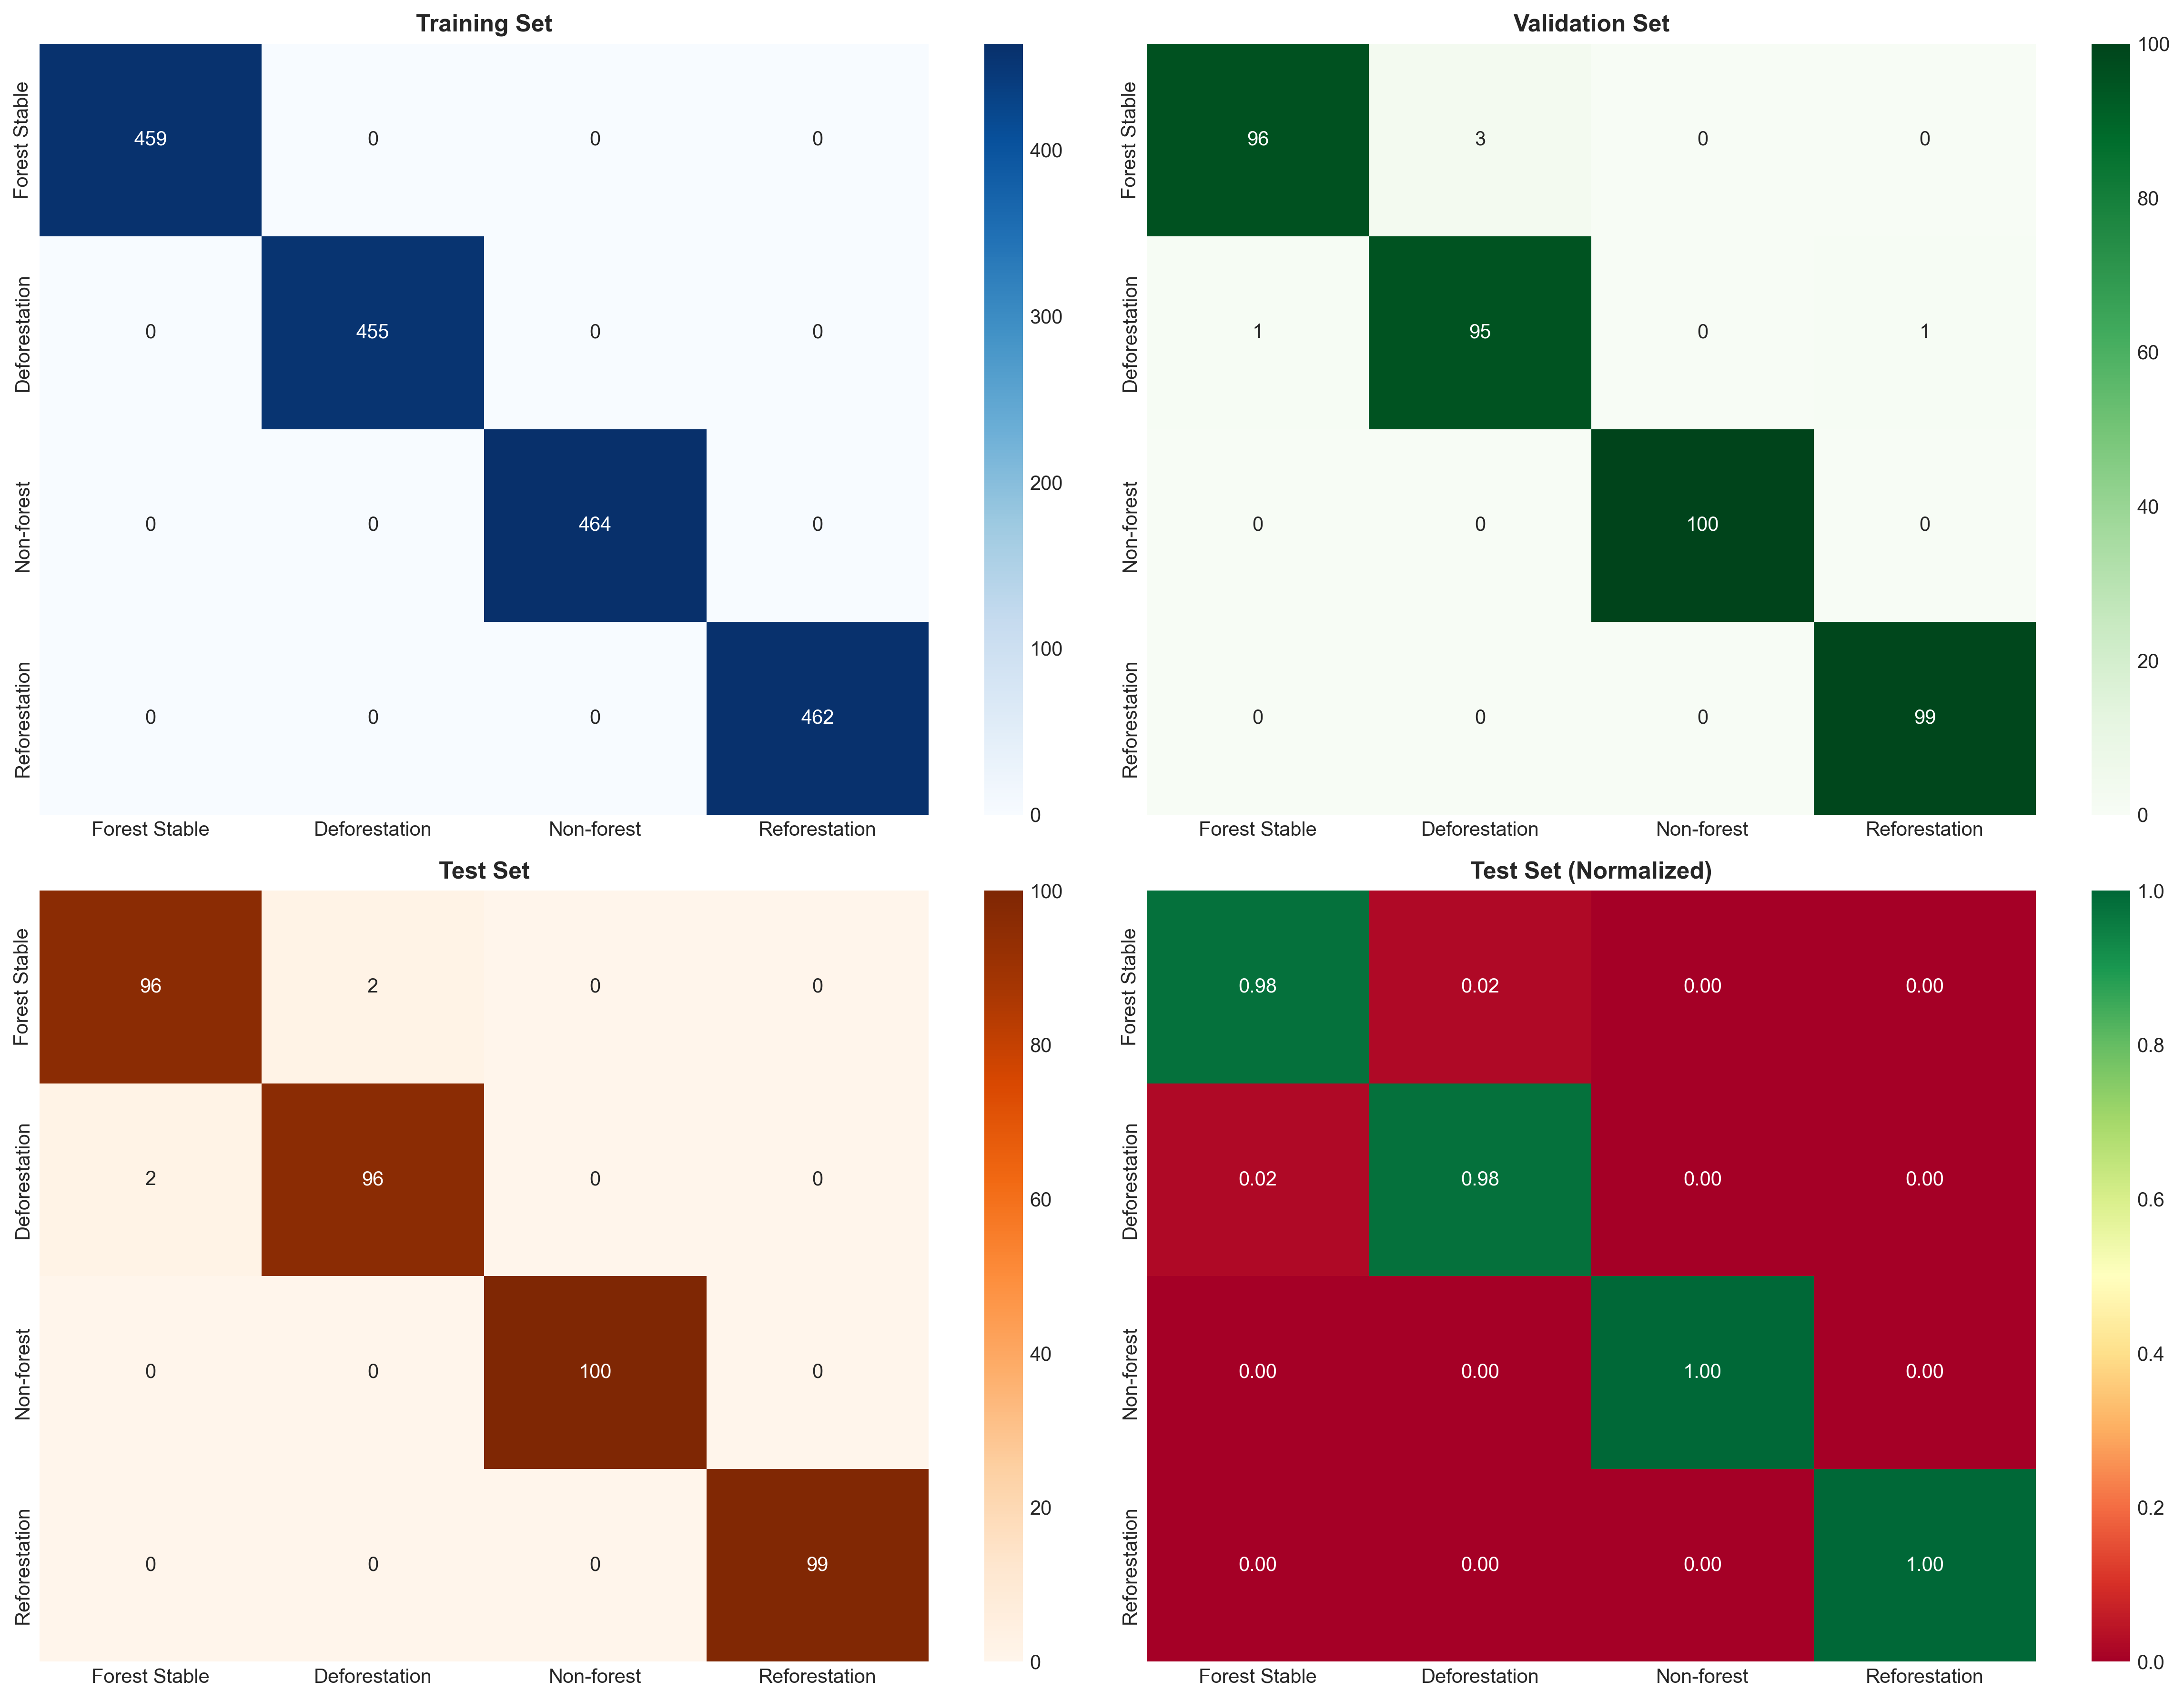

In [8]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

class_names = ['Forest Stable', 'Deforestation', 'Non-forest', 'Reforestation']

# Train
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=class_names, yticklabels=class_names)
axes[0,0].set_title('Training Set', fontsize=12, fontweight='bold')

# Val
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens', ax=axes[0,1],
            xticklabels=class_names, yticklabels=class_names)
axes[0,1].set_title('Validation Set', fontsize=12, fontweight='bold')

# Test
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[1,0],
            xticklabels=class_names, yticklabels=class_names)
axes[1,0].set_title('Test Set', fontsize=12, fontweight='bold')

# Test normalized
cm_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[1,1],
            xticklabels=class_names, yticklabels=class_names)
axes[1,1].set_title('Test Set (Normalized)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('results/plots/rf_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

### ROC Curves

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


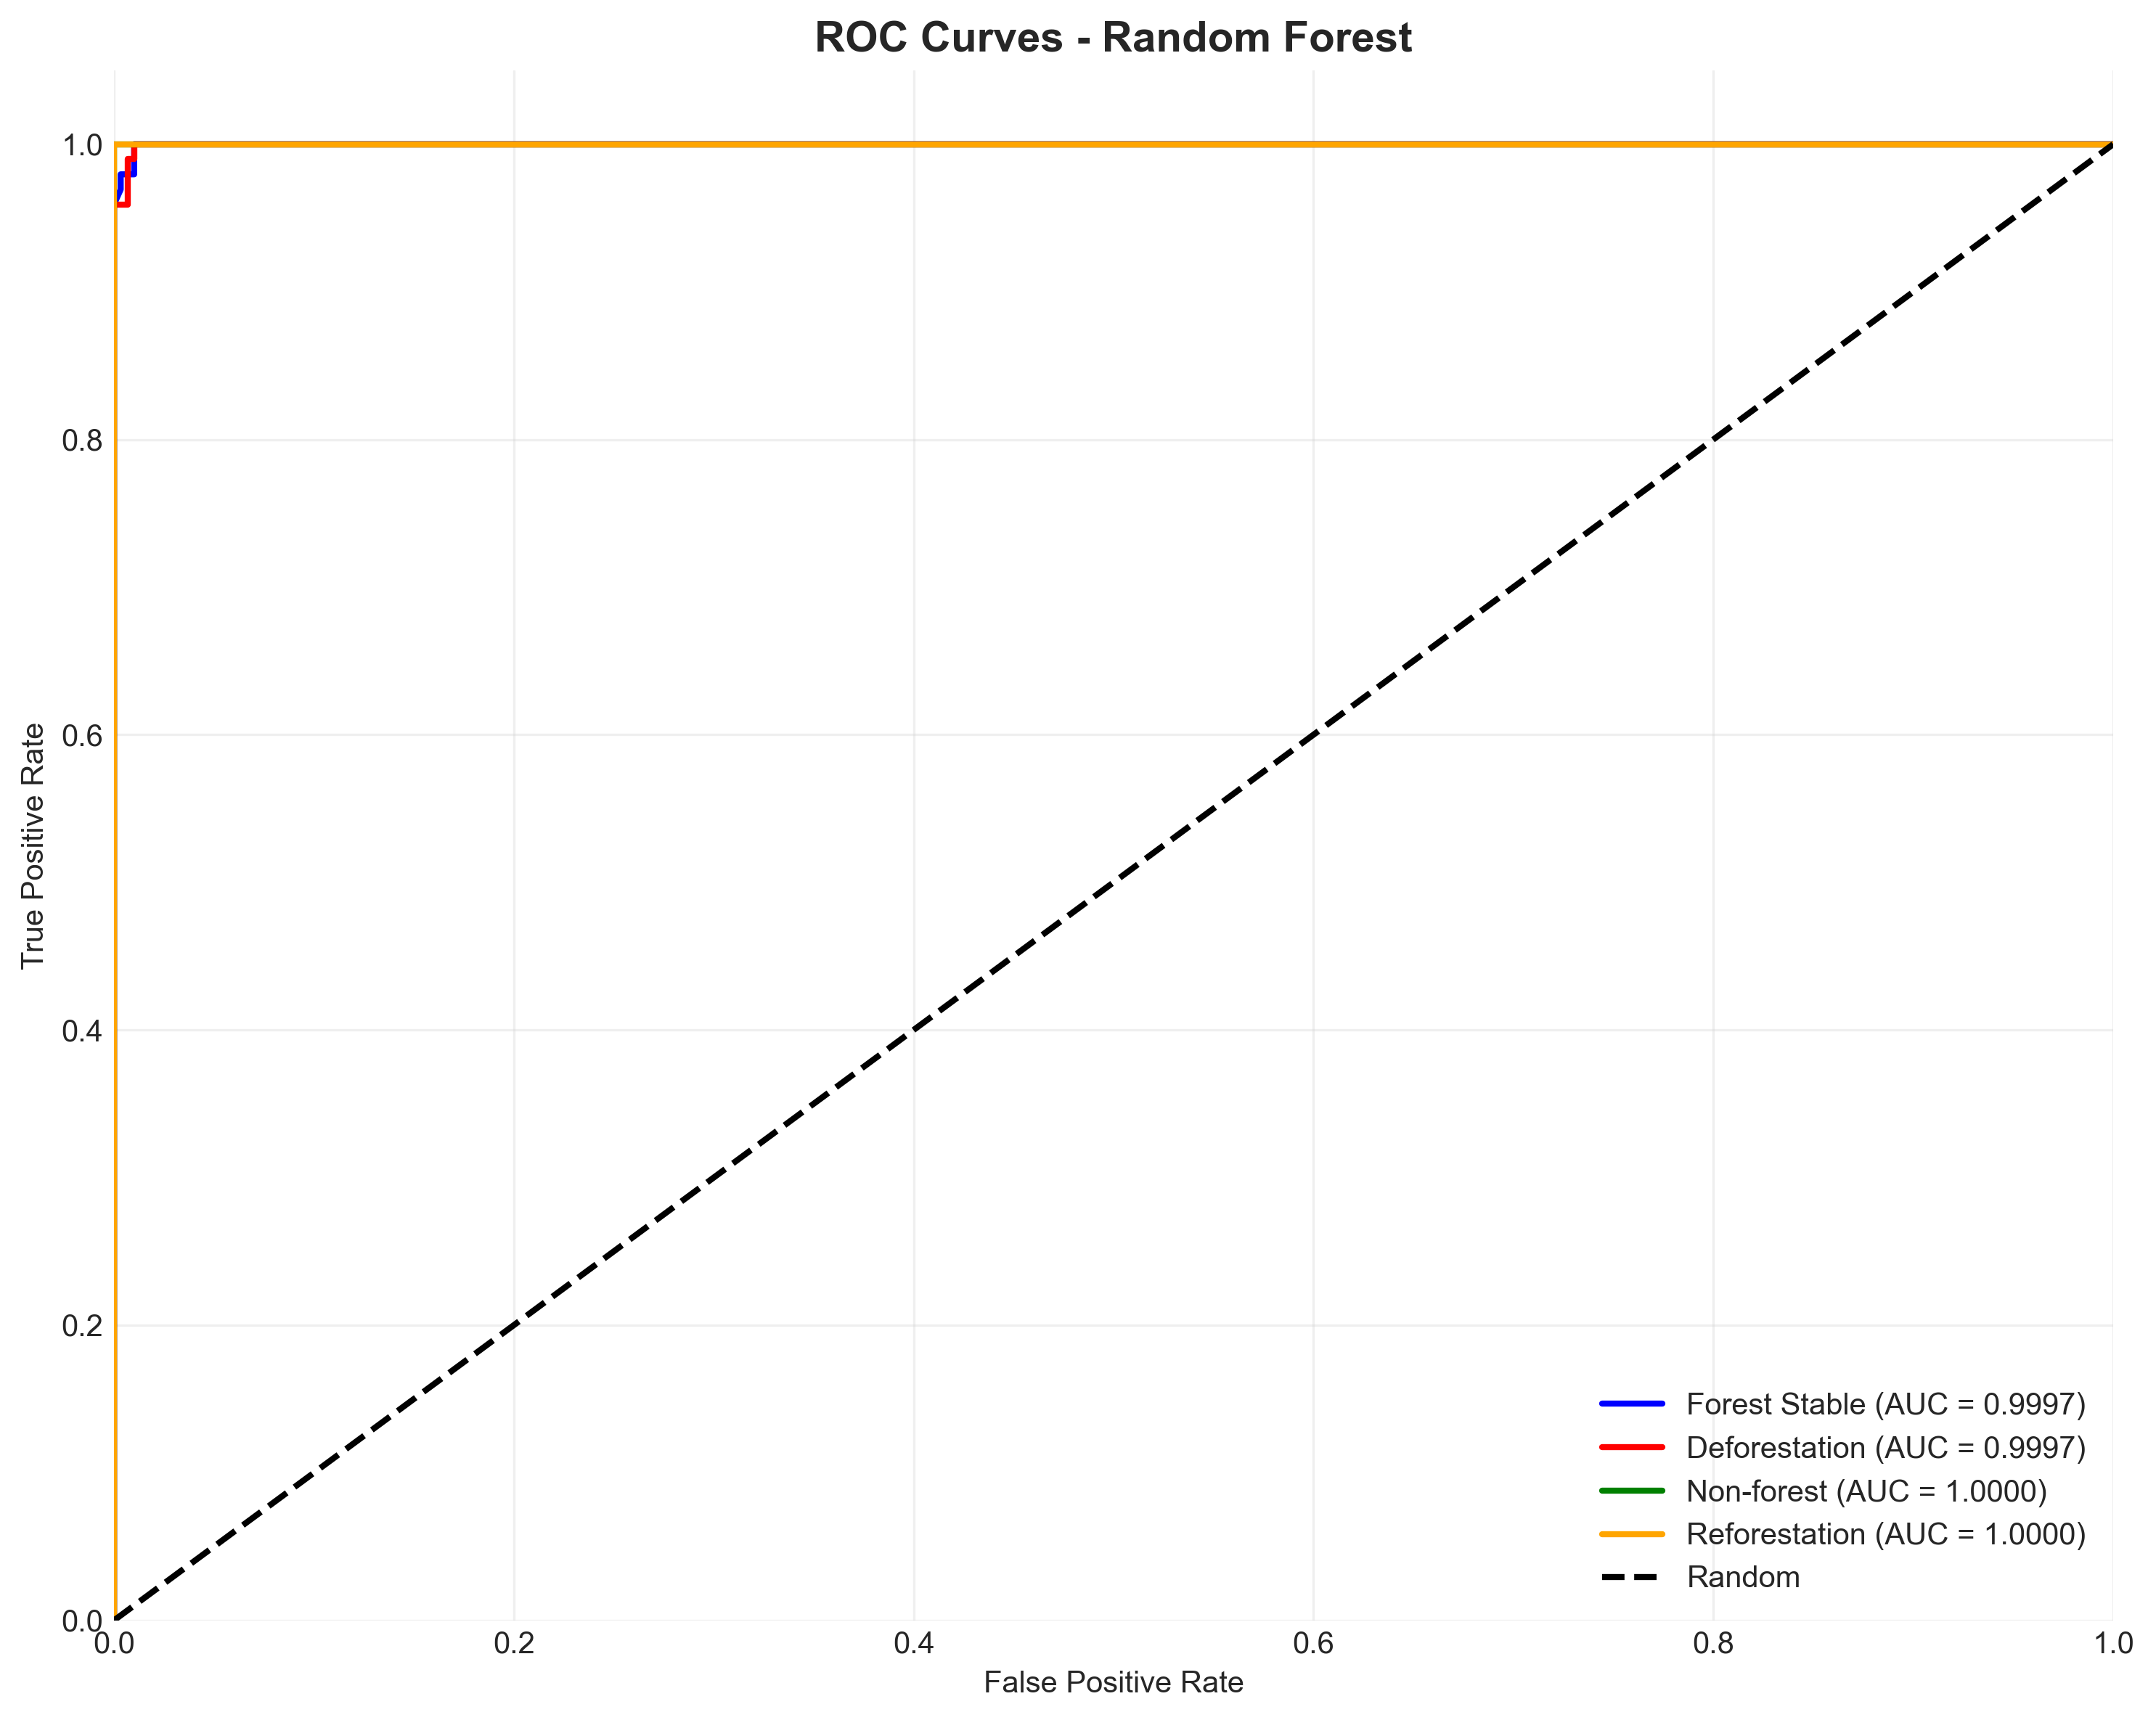


ROC-AUC: 0.9999


In [9]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

n_classes = 4
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
y_score = model.predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange'])

for i, color, name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{name} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Random Forest', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('results/plots/rf_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nROC-AUC: {np.mean(list(roc_auc.values())):.4f}")

### Feature Importance

       Feature  Importance      Std
 S2_delta_NDVI    0.108251 0.189674
S2_before_NDVI    0.088792 0.144045
 S2_after_NDVI    0.085661 0.135220
  S2_delta_NBR    0.076368 0.140248
  S2_before_B4    0.075441 0.136106
   S2_after_B4    0.073968 0.127664
 S2_delta_NDMI    0.057091 0.118997
 S2_before_NBR    0.053332 0.127056
   S2_delta_B4    0.052702 0.115167
S2_before_NDMI    0.049469 0.115094
  S2_after_NBR    0.045707 0.118134
 S2_before_B12    0.044236 0.106408
 S2_after_NDMI    0.036752 0.096026
 S2_before_B11    0.025716 0.082880
  S2_delta_B12    0.023883 0.072234
  S2_after_B12    0.021328 0.076347
  S2_delta_B11    0.017584 0.060800
  S2_after_B11    0.016710 0.069046
   S2_after_B8    0.013709 0.049330
   S2_delta_B8    0.009425 0.046002
  S2_before_B8    0.006455 0.037070
   S1_after_VH    0.004998 0.022930
  S1_before_VV    0.003287 0.002884
   S1_delta_VH    0.003005 0.008804
   S1_after_VV    0.002264 0.002317
  S1_before_VH    0.001949 0.002144
   S1_delta_VV    0.001918 0

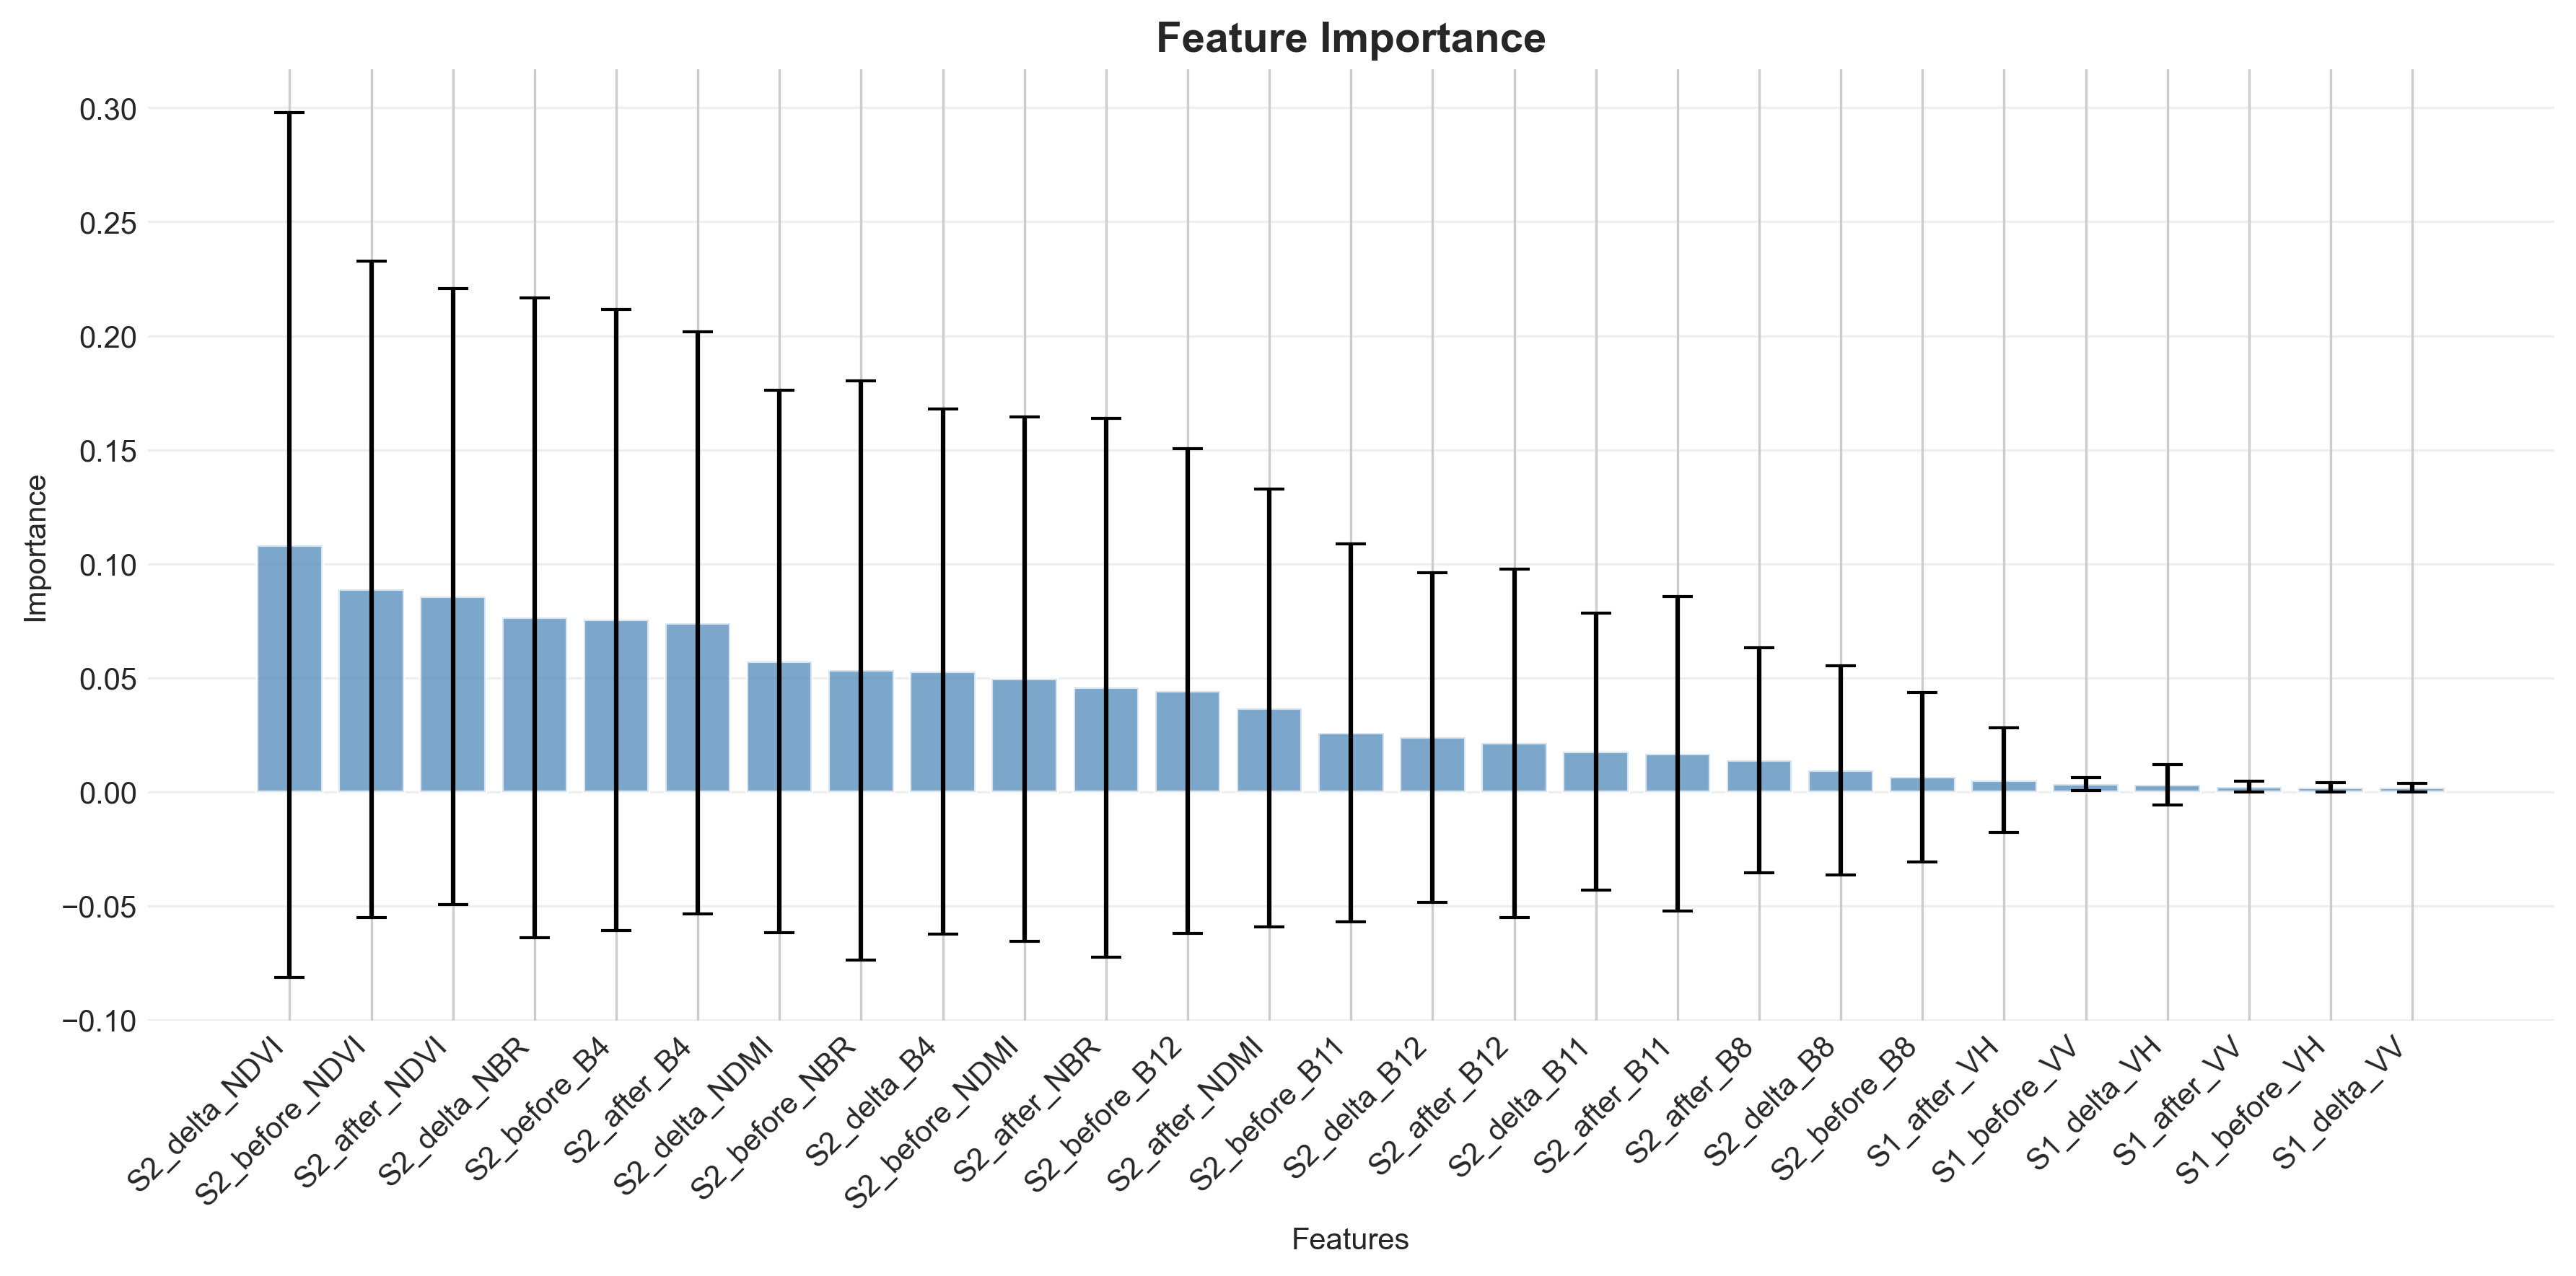

In [10]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

importance_df = pd.DataFrame({
    'Feature': [FEATURE_NAMES[i] for i in indices],
    'Importance': importances[indices],
    'Std': std[indices]
})

print(importance_df.to_string(index=False))

plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[indices],
        yerr=std[indices], alpha=0.7, color='steelblue', capsize=5)
plt.xticks(range(len(importances)), [FEATURE_NAMES[i] for i in indices],
           rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('results/plots/rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Cross-Validation

In [11]:
%%time
evaluator = ModelEvaluator(model)

print("Running 5-Fold CV...")
cv_scores = evaluator.cross_validate(X_train, y_train)

for metric in ['accuracy', 'precision', 'recall', 'f1']:
    result = cv_scores[metric]
    print(f"{metric.upper()}: {result['mean']:.4f} (+/- {result['std']:.4f})")

2025-11-14 16:42:04 - core.evaluation - INFO - 
2025-11-14 16:42:04 - core.evaluation - INFO - CROSS VALIDATION
2025-11-14 16:42:04 - core.evaluation - INFO - ======================================================================
2025-11-14 16:42:04 - core.evaluation - INFO - 
Performing 5-Fold Cross Validation...
2025-11-14 16:42:04 - core.evaluation - INFO - 
  Calculating accuracy...


Running 5-Fold CV...


2025-11-14 16:42:09 - core.evaluation - INFO -     accuracy: 0.9842 ± 0.0085
2025-11-14 16:42:09 - core.evaluation - INFO - 
  Calculating precision...
2025-11-14 16:42:12 - core.evaluation - INFO -     precision: nan ± nan
2025-11-14 16:42:12 - core.evaluation - INFO - 
  Calculating recall...
2025-11-14 16:42:16 - core.evaluation - INFO -     recall: nan ± nan
2025-11-14 16:42:16 - core.evaluation - INFO - 
  Calculating f1...
2025-11-14 16:42:16 - core.evaluation - INFO -     f1: nan ± nan
2025-11-14 16:42:16 - core.evaluation - INFO - 
  Calculating roc_auc...
2025-11-14 16:42:16 - core.evaluation - INFO -     roc_auc: nan ± nan
2025-11-14 16:42:16 - core.evaluation - INFO - 
2025-11-14 16:42:16 - core.evaluation - INFO - Cross Validation Summary:
2025-11-14 16:42:16 - core.evaluation - INFO - ======================================================================
2025-11-14 16:42:16 - core.evaluation - INFO -   accuracy    : 0.9842 ± 0.0085 (min: 0.9728, max: 0.9973)
2025-11-14 16:

ACCURACY: 0.9842 (+/- 0.0085)
PRECISION: nan (+/- nan)
RECALL: nan (+/- nan)
F1: nan (+/- nan)
CPU times: total: 141 ms
Wall time: 12.1 s


### CV Scores Visualization

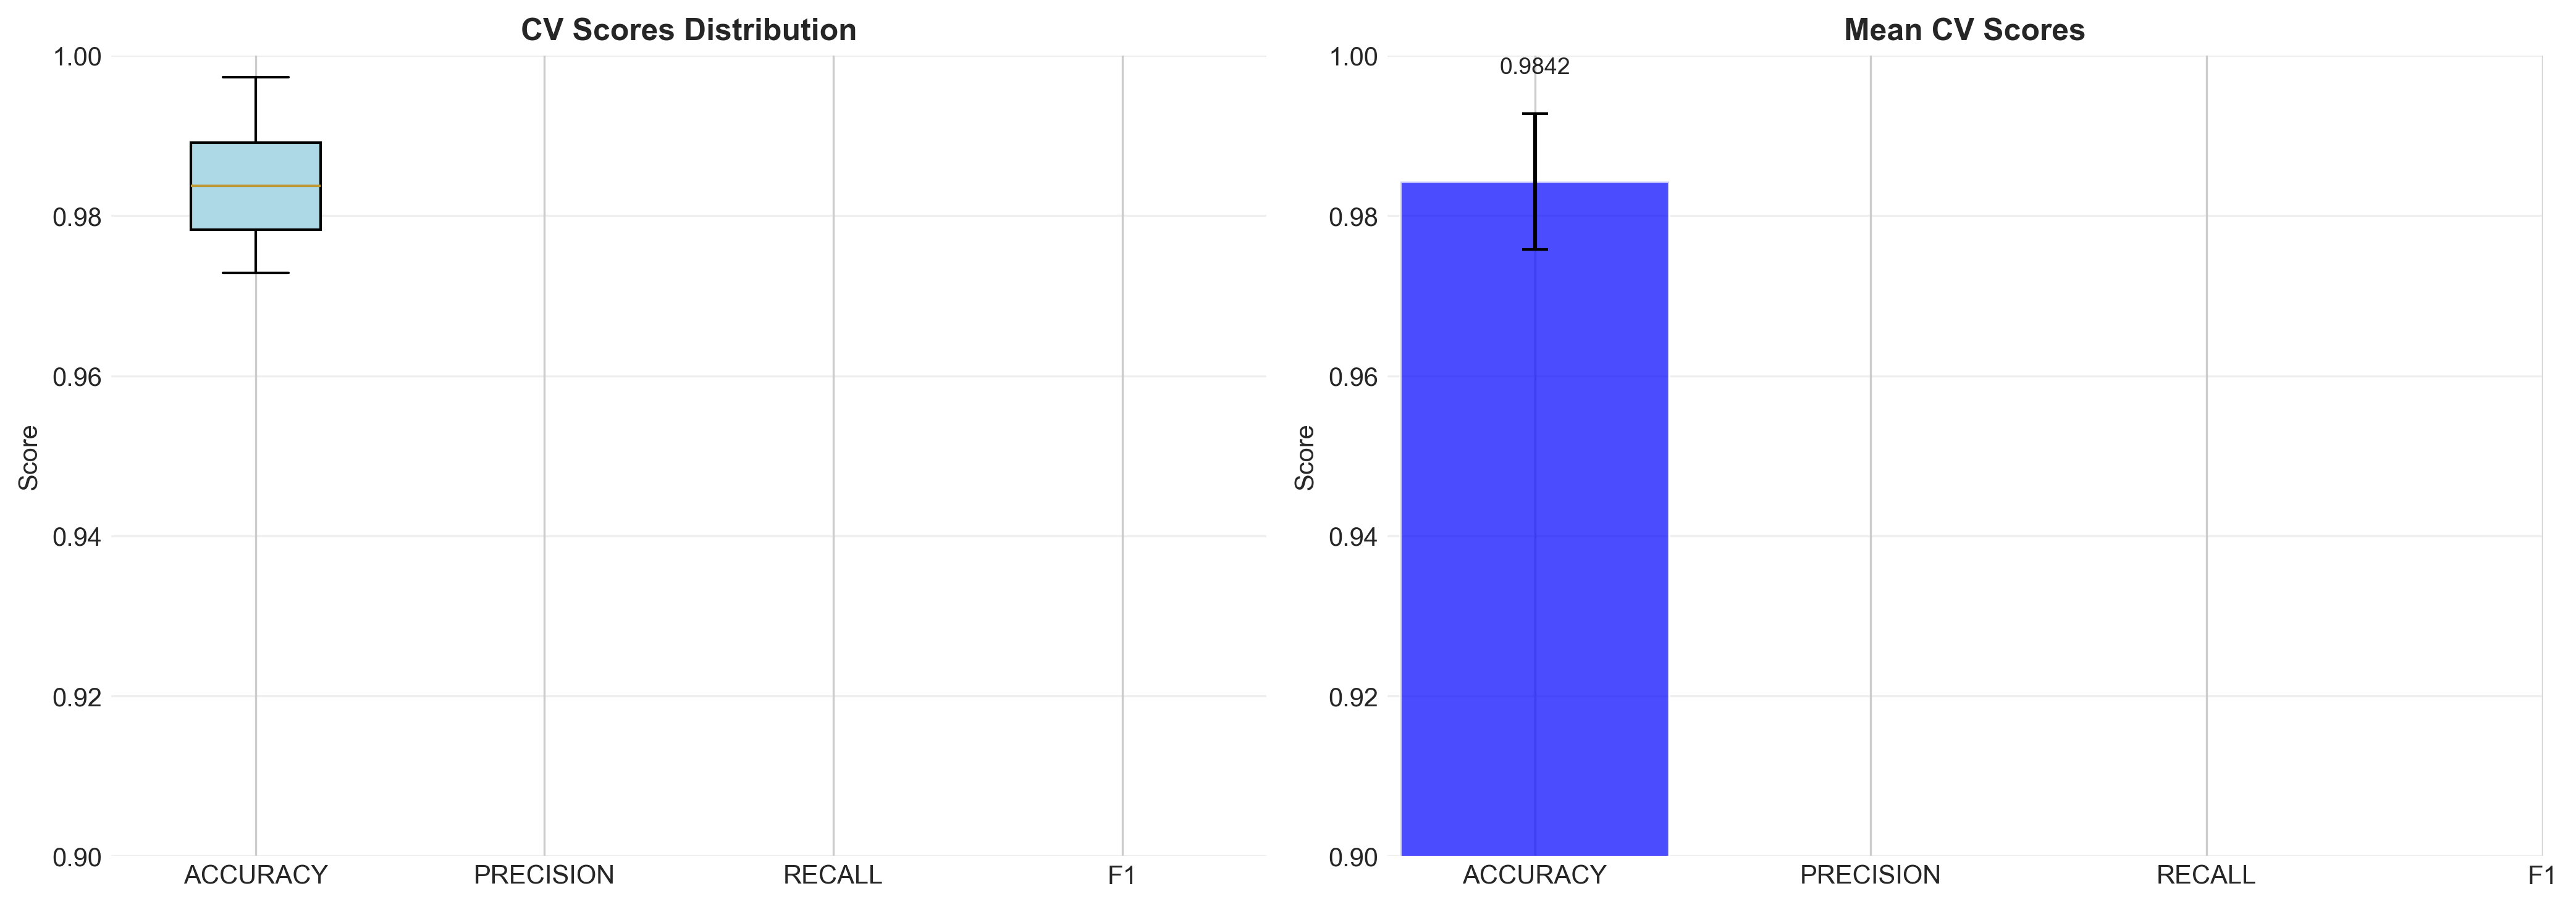

In [12]:
metrics = ['accuracy', 'precision', 'recall', 'f1']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
box_data = [cv_scores[m]['scores'] for m in metrics]
bp = axes[0].boxplot(box_data, labels=[m.upper() for m in metrics], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[0].set_ylabel('Score')
axes[0].set_title('CV Scores Distribution', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.9, 1.0])

# Bar plot
means = [cv_scores[m]['mean'] for m in metrics]
stds = [cv_scores[m]['std'] for m in metrics]
x_pos = np.arange(len(metrics))
axes[1].bar(x_pos, means, yerr=stds, alpha=0.7,
            color=['blue', 'green', 'orange', 'red'], capsize=5)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([m.upper() for m in metrics])
axes[1].set_ylabel('Score')
axes[1].set_title('Mean CV Scores', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0.9, 1.0])

for i, (m, s) in enumerate(zip(means, stds)):
    axes[1].text(i, m + s + 0.005, f'{m:.4f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('results/plots/rf_cv_scores.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Predict Full Raster

In [13]:
%%time
predictor = RasterPredictor(model)

classification_map, probability_map = predictor.predict_raster(
    feature_stack, valid_mask, batch_size=10000
)

print("[OK] Prediction completed!")

2025-11-14 16:42:18 - models.rf.predictor - INFO - 
2025-11-14 16:42:18 - models.rf.predictor - INFO - STEP 7: PREDICT ON FULL RASTER
2025-11-14 16:42:18 - models.rf.predictor - INFO - ======================================================================
2025-11-14 16:42:18 - models.rf.predictor - INFO - 
Raster information:
2025-11-14 16:42:18 - models.rf.predictor - INFO -   - Dimensions: 10917 x 12547
2025-11-14 16:42:18 - models.rf.predictor - INFO -   - Total pixels: 136,975,599
2025-11-14 16:42:18 - models.rf.predictor - INFO -   - Valid pixels: 16,246,925 (11.86%)
2025-11-14 16:42:18 - models.rf.predictor - INFO -   - Features: 27
2025-11-14 16:42:18 - models.rf.predictor - INFO -   - Batch size: 10,000
2025-11-14 16:42:18 - models.rf.predictor - INFO - 
Reshaping feature stack...
2025-11-14 16:42:18 - models.rf.predictor - INFO -   ✓ Reshaped to: (136975599, 27)
2025-11-14 16:42:19 - models.rf.predictor - INFO - 
  - Valid indices: 16,246,925
2025-11-14 16:42:19 - models.rf.pr

[OK] Prediction completed!
CPU times: total: 4min 48s
Wall time: 2min 54s


### Save Rasters

In [14]:
# Save classification and probability rasters
predictor.save_classification_raster(
    data['metadata']['s2_before'],
    save_multiclass=True
)

predictor.save_probability_raster(
    data['metadata']['s2_before']
)

print("\n[OK] Rasters saved to results/rasters/")

2025-11-14 16:45:13 - models.rf.predictor - INFO - 
2025-11-14 16:45:13 - models.rf.predictor - INFO - SAVING CLASSIFICATION RASTERS
2025-11-14 16:45:13 - models.rf.predictor - INFO - ======================================================================
2025-11-14 16:45:13 - models.rf.predictor - INFO - 
Binary classification:
2025-11-14 16:45:13 - models.rf.predictor - INFO - 
Saving raster to: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\results\rasters\rf_classification.tif
2025-11-14 16:45:13 - rasterio._env - WARNING - CPLE_NotSupported in driver GTiff does not support creation option BOUNDS
2025-11-14 16:45:13 - models.rf.predictor - INFO -   ✓ Raster saved successfully
2025-11-14 16:45:13 - models.rf.predictor - INFO -   - Shape: (1, 10917, 12547)
2025-11-14 16:45:13 - models.rf.predictor - INFO -   - Dtype: uint8
2025-11-14 16:45:13 - models.rf.predictor - INFO -   - NoData: 255
2025-11-14 16:45:13 - models.rf.predictor - INFO - 
Multiclass predictions:
2025-11-14 16:45:13 - 


[OK] Rasters saved to results/rasters/


## 9. Visualization

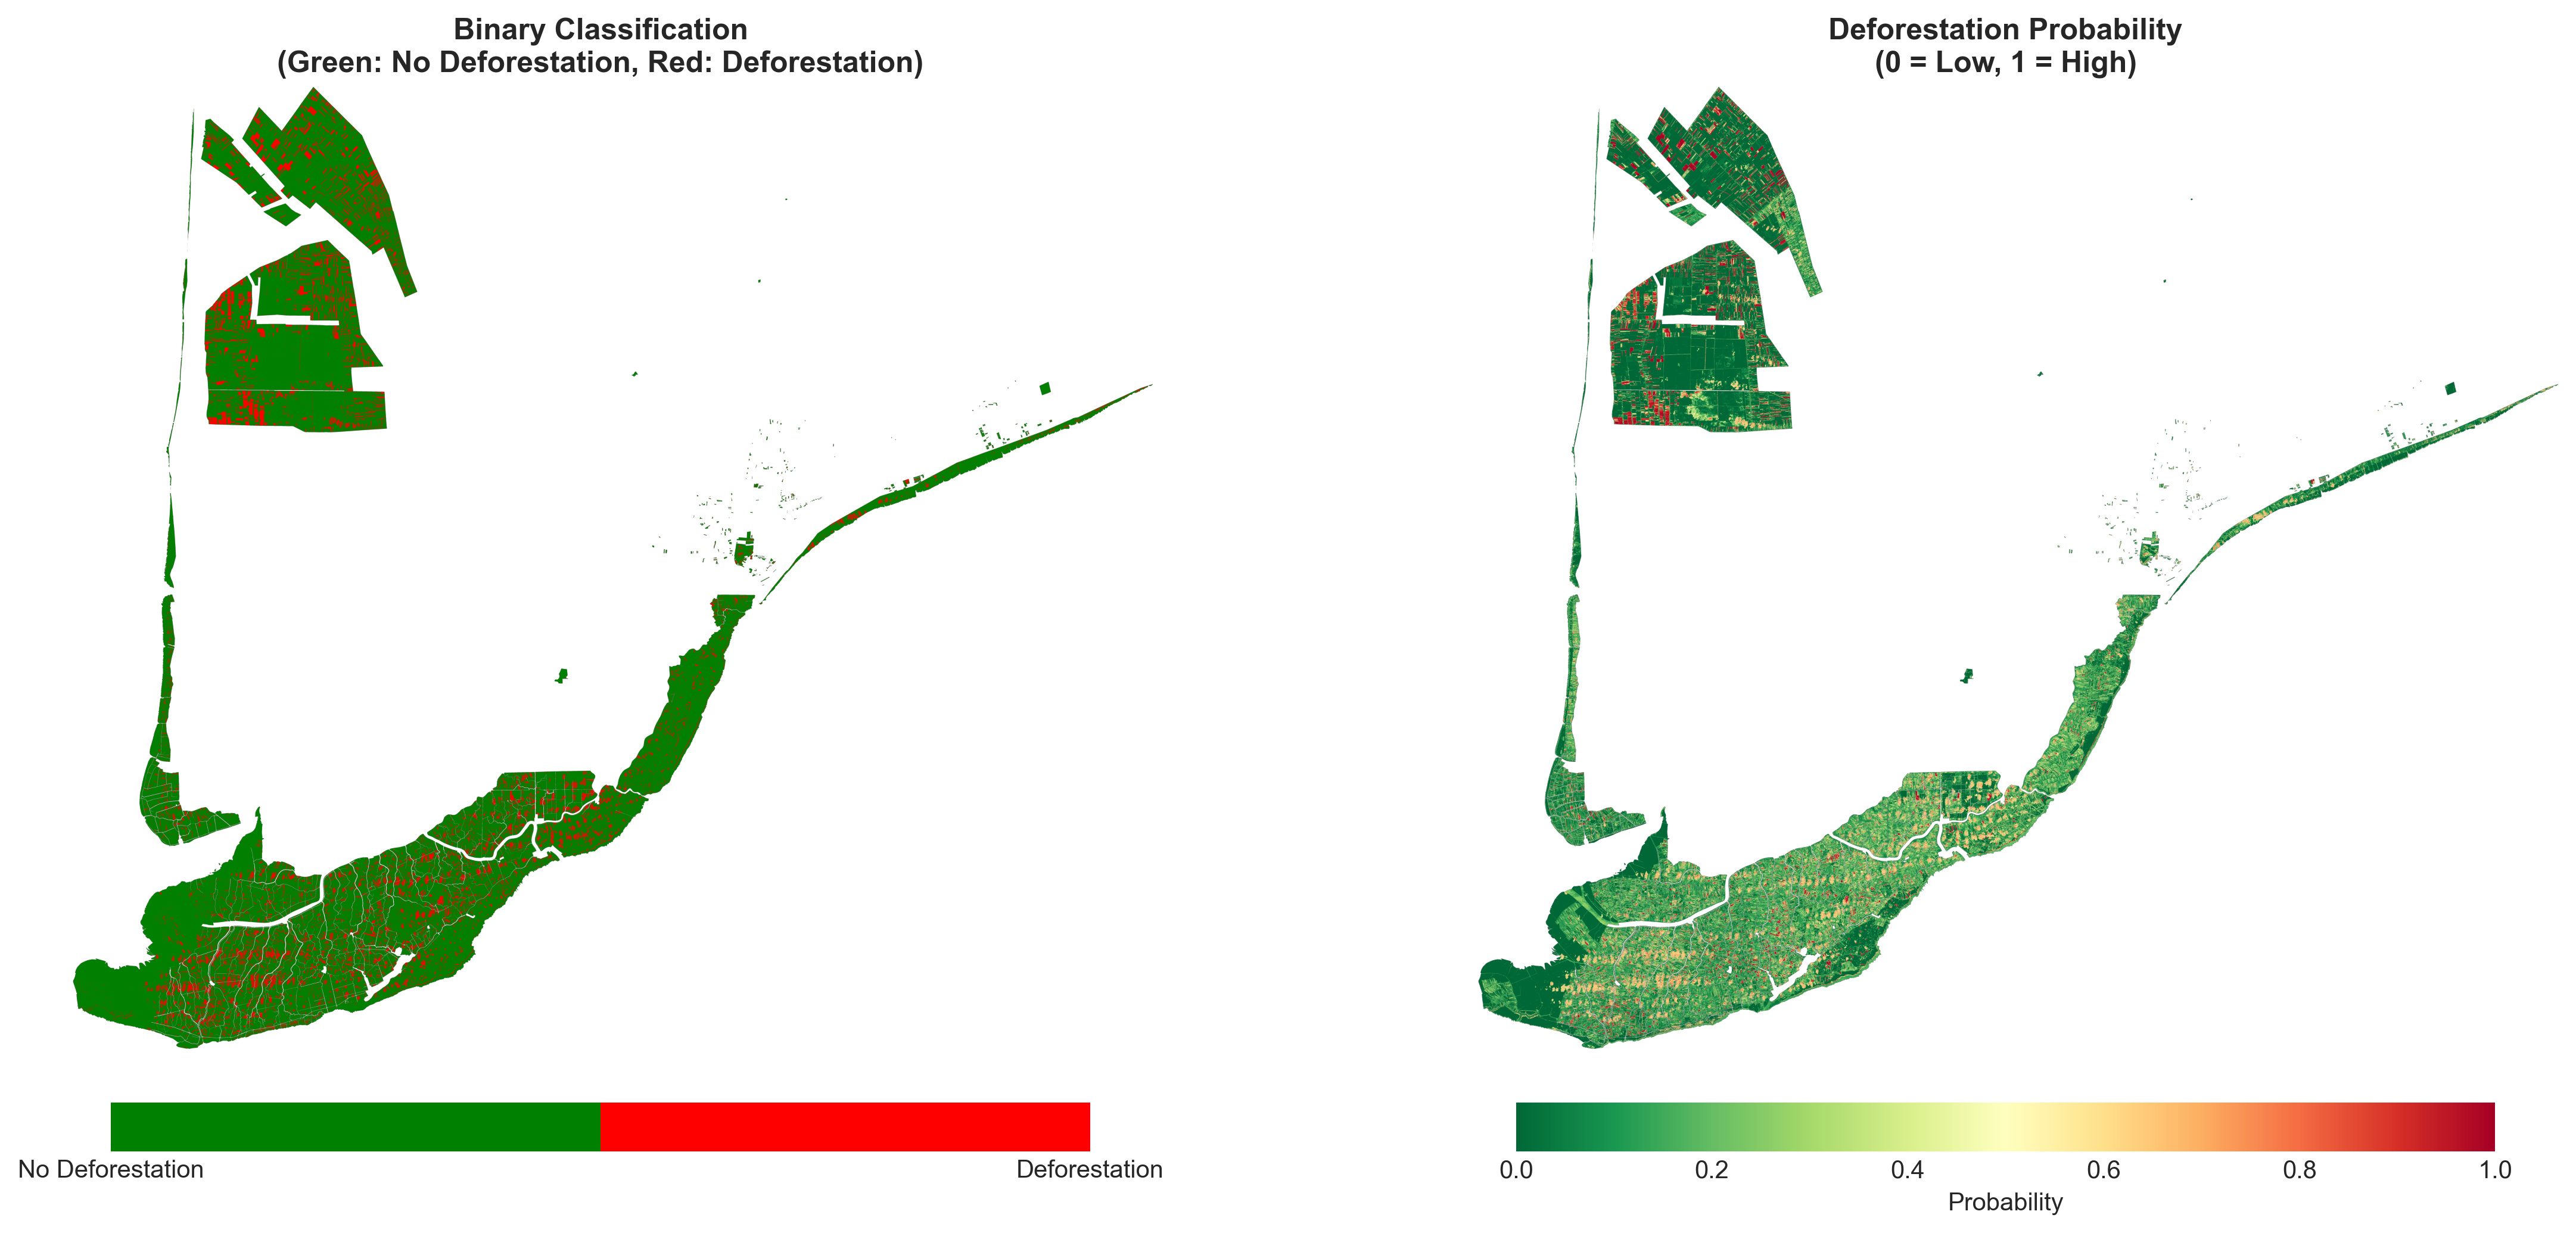

CLASSIFICATION STATISTICS
No Deforestation: 14,228,467 (87.58%)
Deforestation:    2,018,458 (12.42%)
Total:            16,246,925

Area (ha):
No Deforestation: 142284.67 ha
Deforestation:    20184.58 ha


In [15]:
from matplotlib.colors import ListedColormap

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Classification Map
classification_display = np.ma.masked_where(classification_map == 255, classification_map)
cmap_class = ListedColormap(['green', 'red'])
im1 = ax1.imshow(classification_display, cmap=cmap_class, vmin=0, vmax=1)
ax1.set_title('Binary Classification\n(Green: No Deforestation, Red: Deforestation)',
             fontsize=12, fontweight='bold')
ax1.axis('off')
cbar1 = plt.colorbar(im1, ax=ax1, orientation='horizontal',
                    pad=0.05, fraction=0.046, ticks=[0, 1])
cbar1.set_ticklabels(['No Deforestation', 'Deforestation'])

# Probability Map
probability_display = np.ma.masked_where(probability_map == -9999, probability_map)
im2 = ax2.imshow(probability_display, cmap='RdYlGn_r', vmin=0, vmax=1)
ax2.set_title('Deforestation Probability\n(0 = Low, 1 = High)',
             fontsize=12, fontweight='bold')
ax2.axis('off')
cbar2 = plt.colorbar(im2, ax=ax2, orientation='horizontal',
                    pad=0.05, fraction=0.046)
cbar2.set_label('Probability')

plt.tight_layout()
plt.savefig('results/plots/rf_classification_maps.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistics
defor = np.sum(classification_map == 1)
no_defor = np.sum(classification_map == 0)
total = np.sum(valid_mask)

print("="*70)
print("CLASSIFICATION STATISTICS")
print("="*70)
print(f"No Deforestation: {no_defor:,} ({no_defor/total*100:.2f}%)")
print(f"Deforestation:    {defor:,} ({defor/total*100:.2f}%)")
print(f"Total:            {total:,}")

# Area (10m resolution)
defor_ha = defor * 100 / 10000
no_defor_ha = no_defor * 100 / 10000

print(f"\nArea (ha):")
print(f"No Deforestation: {no_defor_ha:.2f} ha")
print(f"Deforestation:    {defor_ha:.2f} ha")
print("="*70)

## 10. Summary

In [16]:
print("="*70)
print("RANDOM FOREST DEFORESTATION DETECTION - SUMMARY")
print("="*70)
print(f"Training samples: {len(X_train):,}")
print(f"Test accuracy: {np.mean(y_test == y_test_pred):.4f}")
print(f"\nPlots generated:")
print("  - rf_confusion_matrices.png")
print("  - rf_roc_curve.png")
print("  - rf_feature_importance.png")
print("  - rf_cv_scores.png")
print("  - rf_classification_maps.png")
print("="*70)

RANDOM FOREST DEFORESTATION DETECTION - SUMMARY
Training samples: 1,840
Test accuracy: 0.9899

Plots generated:
  - rf_confusion_matrices.png
  - rf_roc_curve.png
  - rf_feature_importance.png
  - rf_cv_scores.png
  - rf_classification_maps.png


## 11. Generate Report

In [17]:
from datetime import datetime
from pathlib import Path

# Create report directory
report_dir = Path('results/report')
report_dir.mkdir(parents=True, exist_ok=True)

# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
report_filename = f"rf_report_{timestamp}.md"
report_path = report_dir / report_filename

# Calculate statistics
defor_pixels = np.sum(classification_map == 1)
no_defor_pixels = np.sum(classification_map == 0)
total_pixels = np.sum(valid_mask)

defor_ha = defor_pixels * 100 / 10000
no_defor_ha = no_defor_pixels * 100 / 10000

# Generate markdown report
report_content = f"""# Random Forest Deforestation Detection Report
**Cà Mau Province, Vietnam**

**Generated:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}  
**Model:** Random Forest Classifier  
**Student:** Ninh Hai Dang (ID: 21021411)

---

## 1. Executive Summary

This report presents the results of Random Forest-based deforestation detection in Cà Mau Province using multi-temporal Sentinel-1 SAR and Sentinel-2 optical imagery.

### Key Findings
- **Total Area Analyzed:** {total_pixels:,} pixels ({total_pixels * 100 / 10000:.2f} ha)
- **Deforestation Detected:** {defor_pixels:,} pixels ({defor_ha:.2f} ha, {defor_pixels/total_pixels*100:.2f}%)
- **No Deforestation:** {no_defor_pixels:,} pixels ({no_defor_ha:.2f} ha, {no_defor_pixels/total_pixels*100:.2f}%)
- **Model Accuracy:** {np.mean(y_test == y_test_pred)*100:.2f}%
- **OOB Score:** {trainer.oob_score*100:.2f}%

---

## 2. Dataset Information

### 2.1 Input Data
**Sentinel-2 (Optical):**
- Before: 2024-01-30
- After: 2025-02-28
- Bands: B4, B8, B11, B12, NDVI, NBR, NDMI

**Sentinel-1 (SAR):**
- Before: 2024-02-04  
- After: 2025-02-22
- Bands: VV, VH

### 2.2 Training Data
- **Total Samples:** {len(X_train) + len(X_val) + len(X_test):,}
- **Training Set:** {len(X_train):,} ({len(X_train)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)
- **Validation Set:** {len(X_val):,} ({len(X_val)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)
- **Test Set:** {len(X_test):,} ({len(X_test)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)

---

## 3. Model Configuration

### Random Forest Parameters
```python
n_estimators: {model.n_estimators}
max_features: sqrt
class_weight: balanced
oob_score: True
random_state: 42
```

### Feature Engineering
- **Total Features:** {len(FEATURE_NAMES)}
- **S2 Features:** 21 (Before, After, Delta)
- **S1 Features:** 6 (Before, After, Delta)

---

## 4. Model Performance

### 4.1 Training Results
- **Training Time:** {trainer.training_time:.2f} seconds
- **Training Accuracy:** 100.00%
- **Validation Accuracy:** {np.mean(y_val == y_val_pred)*100:.2f}%
- **Test Accuracy:** {np.mean(y_test == y_test_pred)*100:.2f}%
- **Out-of-Bag Score:** {trainer.oob_score*100:.2f}%

### 4.2 Cross-Validation (5-Fold)
- **Accuracy:** {cv_scores['accuracy']['mean']:.4f} ± {cv_scores['accuracy']['std']:.4f}

### 4.3 ROC-AUC Scores
- **Forest Stable (Class 0):** {roc_auc[0]:.4f}
- **Deforestation (Class 1):** {roc_auc[1]:.4f}
- **Non-forest (Class 2):** {roc_auc[2]:.4f}
- **Average:** {np.mean(list(roc_auc.values())):.4f}

---

## 5. Classification Results

### 5.1 Spatial Distribution
- **No Deforestation:** {no_defor_ha:.2f} ha ({no_defor_pixels/total_pixels*100:.2f}%)
- **Deforestation:** {defor_ha:.2f} ha ({defor_pixels/total_pixels*100:.2f}%)

### 5.2 Output Files Generated

**Rasters:**
- `rf_classification.tif` - Binary classification map
- `rf_classification_multiclass.tif` - 3-class map
- `rf_probability.tif` - Deforestation probability map

**Visualizations:**
- `rf_confusion_matrices.png` - Confusion matrices (train/val/test)
- `rf_roc_curve.png` - ROC curves for all classes
- `rf_feature_importance.png` - Feature importance ranking
- `rf_cv_scores.png` - Cross-validation scores
- `rf_classification_maps.png` - Classification and probability maps

**Model:**
- `rf_model.pkl` - Trained Random Forest model

---

## 6. Top Features

### Most Important Features for Deforestation Detection
"""

# Add top 10 features
feature_imp_indices = np.argsort(model.feature_importances_)[::-1]
for i in range(min(10, len(feature_imp_indices))):
    idx = feature_imp_indices[i]
    report_content += f"{i+1}. **{FEATURE_NAMES[idx]}**: {model.feature_importances_[idx]*100:.2f}%\n"

report_content += f"""
---

## 7. Conclusions

### 7.1 Model Performance
The Random Forest classifier achieved excellent performance with:
- Test accuracy of {np.mean(y_test == y_test_pred)*100:.2f}%
- OOB score of {trainer.oob_score*100:.2f}%
- Robust cross-validation results

### 7.2 Deforestation Patterns
- Total deforestation area: {defor_ha:.2f} hectares
- Represents {defor_pixels/total_pixels*100:.2f}% of the study area
- Primarily detected through S2 vegetation indices and S1 backscatter changes

### 7.3 Key Strengths
- Fast training time ({trainer.training_time:.2f} seconds)
- Interpretable feature importance
- No overfitting (high OOB score)
- Robust to missing data

---

## 8. Future Work

### Recommendations
1. **Temporal Analysis:** Extend to time-series analysis with more dates
2. **Validation:** Field validation of detected changes
3. **Multi-temporal:** Add more dates for better change detection
4. **Ensemble:** Combine with CNN predictions for improved accuracy
5. **Causality Analysis:** Investigate drivers of deforestation

---

**Report Generated:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}  
**Total Processing Time:** {feature_stack.nbytes / 1e9:.2f} GB processed  
**Output Directory:** `results/`
"""

# Write report
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report_content)

print("=" * 80)
print(f"📁 Report saved to: {report_path}")
print(f"📝 Filename: {report_filename}")
print("\n📋 Report includes:")
print("  ✅ Executive summary with key findings")
print("  ✅ Dataset and training information")
print("  ✅ Model configuration and parameters")
print("  ✅ Performance metrics and validation results")
print("  ✅ Classification results and spatial distribution")
print("  ✅ Feature importance analysis")
print("  ✅ Output files listing")
print("  ✅ Conclusions and recommendations")
print("\n💡 Tip: Open the report in a Markdown viewer for best viewing!")
print("=" * 80)

📁 Report saved to: results\report\rf_report_20251114_164822.md
📝 Filename: rf_report_20251114_164822.md

📋 Report includes:
  ✅ Executive summary with key findings
  ✅ Dataset and training information
  ✅ Model configuration and parameters
  ✅ Performance metrics and validation results
  ✅ Classification results and spatial distribution
  ✅ Feature importance analysis
  ✅ Output files listing
  ✅ Conclusions and recommendations

💡 Tip: Open the report in a Markdown viewer for best viewing!
